<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/W207_Breast_Cancer_IDC_Prediction_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**
 

#Predicting IDC (Invasive Ductal Carcinoma 침윤성 유관암) with Breast Histopathology (조직병리학) Images using a CNN

In [33]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
%pwd

'/content'

## Load data as a zip file directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images) to Colab

In [35]:
# !kaggle datasets download -d paultimothymooney/breast-histopathology-images

## Unzip the downloaded zip and remove the original zip file

In [36]:
# !unzip \*.zip && rm *.zip

In [37]:
%ls

10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

## Read image files from **IDC_regular_ps50_idx5**

In [38]:
def read_image_files(binary_class):
  current_working_dir = os.getcwd()
  folder = 'IDC_regular_ps50_idx5/*/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)    
  return image_files_wo_path, image_files_w_path

class_1_malignant_wo_path, class_1_malignant_w_path = read_image_files('1')
class_0_benign_wo_path, class_0_benign_w_path = read_image_files('0')
full_data_wo_path = class_1_malignant_wo_path + class_0_benign_wo_path
full_data_w_path = class_1_malignant_w_path + class_0_benign_w_path

print('class_1:\n',class_1_malignant_wo_path[:2])
print('\nclass_0:\n',class_0_benign_wo_path[:2])
print('\nclass_1 and class_0 combined:\n',full_data_wo_path[0], ',', full_data_wo_path[-1])
print('\nclass_1 with full path:\n',class_1_malignant_w_path[:2])

class_1:
 ['15512_idx5_x501_y1351_class1.png', '15512_idx5_x851_y751_class1.png']

class_0:
 ['15512_idx5_x1101_y651_class0.png', '15512_idx5_x1001_y601_class0.png']

class_1 and class_0 combined:
 15512_idx5_x501_y1351_class1.png , 10293_idx5_x801_y1851_class0.png

class_1 with full path:
 ['/content/IDC_regular_ps50_idx5/15512/1/15512_idx5_x501_y1351_class1.png', '/content/IDC_regular_ps50_idx5/15512/1/15512_idx5_x851_y751_class1.png']


## Check the number of image files in each class


In [39]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count = ', class_1_size + class_0_size)
  return df_perc

check_class_size(class_1_malignant_wo_path, class_0_benign_wo_path)

Total Count =  277524


,class,class_count,class_percent(%)
0,Class 1 (Malignant),78786,28.39
1,Class 0 (Benign),198738,71.61


## Create dataframes for each class

In [78]:
def create_class_df(): 
  image_list_w_path = [x for x in class_1_malignant_w_path]
  image_list_w_path.extend([x for x in class_0_benign_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_malignant_w_path), ['Non_IDC']*len(class_0_benign_w_path)]), columns=['class'])
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

df_full = create_class_df()
df_full

Shape:  (277524, 2)


,class,image
0,IDC,/content/IDC_regular_ps50_idx5/15512/1/15512_i...
1,IDC,/content/IDC_regular_ps50_idx5/15512/1/15512_i...
2,IDC,/content/IDC_regular_ps50_idx5/15512/1/15512_i...
3,IDC,/content/IDC_regular_ps50_idx5/15512/1/15512_i...
4,IDC,/content/IDC_regular_ps50_idx5/15512/1/15512_i...
...,...,...
277519,Non_IDC,/content/IDC_regular_ps50_idx5/10293/0/10293_i...
277520,Non_IDC,/content/IDC_regular_ps50_idx5/10293/0/10293_i...
277521,Non_IDC,/content/IDC_regular_ps50_idx5/10293/0/10293_i...
277522,Non_IDC,/content/IDC_regular_ps50_idx5/10293/0/10293_i...


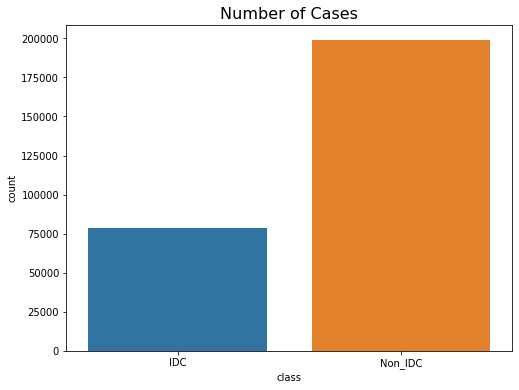

In [79]:
plt.figure(figsize=(8,6))
plt.title('Number of Cases', fontsize=16)
sns.countplot(df_full['class'], data=df_full)
plt.show()

# 1. Binary Classification 
: IDC vs Non-IDC



## Display the first 5 images for each class
: 512 (width) by 512 (height) array of pixel values per image

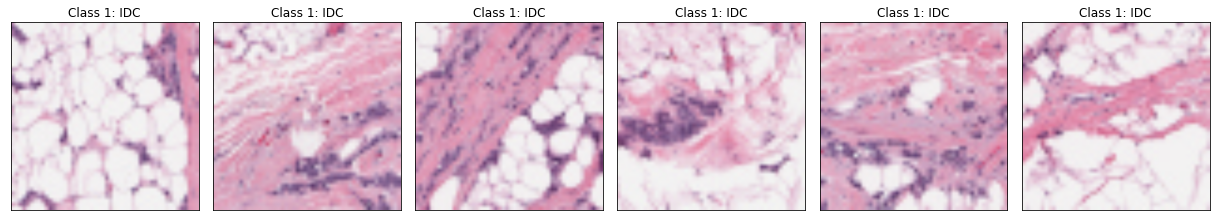

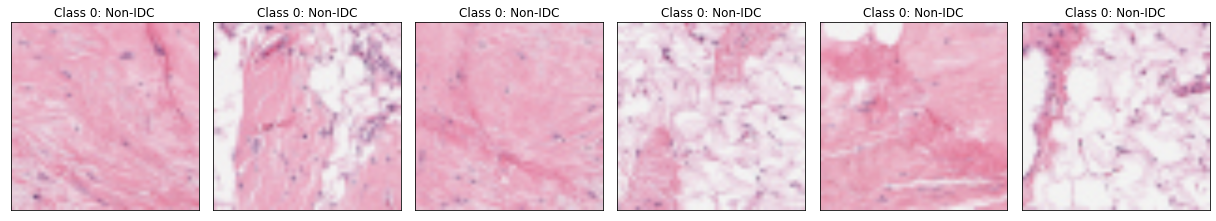

In [80]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (512,512))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(class_1_malignant_w_path, 'Class 1: IDC')
display_images(class_0_benign_w_path, 'Class 0: Non-IDC')

## Randomize images 


In [ ]:
#  randomize image data
def shuffle_data(df):
  indexes = np.arange(df.shape[0])
  print('indexes:', indexes)

  np.random.seed(0)    # get the same results each time    ??????
  shuffled_indexes = np.random.permutation(indexes)
  print('shuffled indexes:', shuffled_indexes, '\n')

  # change the ordering of the original df_features using .reindex()
  df = df_full.reindex(shuffled_indexes)
  return df
df_full = shuffle_data(df_full)
display(df_full)

indexes: [     0      1      2 ... 277521 277522 277523]
shuffled indexes: [106139   3019  55132 ... 122579 152315 117952] 



,class,image
106139,Non_IDC,/content/IDC_regular_ps50_idx5/12897/0/12897_i...
3019,IDC,/content/IDC_regular_ps50_idx5/8917/1/8917_idx...
55132,IDC,/content/IDC_regular_ps50_idx5/9256/1/9256_idx...
29918,IDC,/content/IDC_regular_ps50_idx5/10275/1/10275_i...
25418,IDC,/content/IDC_regular_ps50_idx5/14154/1/14154_i...
...,...,...
211543,Non_IDC,/content/IDC_regular_ps50_idx5/12931/0/12931_i...
86293,Non_IDC,/content/IDC_regular_ps50_idx5/15902/0/15902_i...
122579,Non_IDC,/content/IDC_regular_ps50_idx5/8913/0/8913_idx...
152315,Non_IDC,/content/IDC_regular_ps50_idx5/10286/0/10286_i...


## Train/Test Split & Feature Selection

In [97]:
def data_split_and_feature_selection(df, feat_idx):
  split_boundary = int(df.shape[0]*.8)
  train = pd.DataFrame(df.iloc[:split_boundary, feat_idx:])
  test = pd.DataFrame(df.iloc[split_boundary:, feat_idx:])
  return train, test

train, test = data_split_and_feature_selection(df_full, 0)
print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))

Train Shape:  (222019, 2) 
           class                                              image
106139  Non_IDC  /content/IDC_regular_ps50_idx5/12897/0/12897_i...
3019        IDC  /content/IDC_regular_ps50_idx5/8917/1/8917_idx...
55132       IDC  /content/IDC_regular_ps50_idx5/9256/1/9256_idx...

Test Shape:  (55505, 2) 
           class                                              image
201175  Non_IDC  /content/IDC_regular_ps50_idx5/12934/0/12934_i...
54014       IDC  /content/IDC_regular_ps50_idx5/14081/1/14081_i...
84344   Non_IDC  /content/IDC_regular_ps50_idx5/9076/0/9076_idx...


## Set 20% of validation data out of training dataset
We don't want to just optimize our model and its hyperparameters for just these train and test data sets. There is a chance that the model will perform badly on unseen data because it hasn't really had the chance to test itself against one. 

To mitigate this, we'll take 20% of our training data and put it into validation data. We'll be optimizing our model on these two before introducing it to our test dataset.

In [99]:
'''
set random_state for repeatability and stratify to make the function understand 
that the portion we split from original df must contain the same proportion of elements as in the original df. 
i.e. suppose for every 10 observations you have 7 IDC and 3 non-IDC in the training dataset. we want the same proportion in the validataion as well.
'''
train_df, val_df = train_test_split(train, test_size=0.2, random_state=13, stratify=train['class'])

In [100]:
print(val_df.shape)
val_df

(44404, 2)


,class,image
78531,IDC,/content/IDC_regular_ps50_idx5/9081/1/9081_idx...
67951,IDC,/content/IDC_regular_ps50_idx5/9346/1/9346_idx...
219990,Non_IDC,/content/IDC_regular_ps50_idx5/9123/0/9123_idx...
135073,Non_IDC,/content/IDC_regular_ps50_idx5/12949/0/12949_i...
211291,Non_IDC,/content/IDC_regular_ps50_idx5/12931/0/12931_i...
...,...,...
192704,Non_IDC,/content/IDC_regular_ps50_idx5/10305/0/10305_i...
215192,Non_IDC,/content/IDC_regular_ps50_idx5/16014/0/16014_i...
183559,Non_IDC,/content/IDC_regular_ps50_idx5/12867/0/12867_i...
133401,Non_IDC,/content/IDC_regular_ps50_idx5/12955/0/12955_i...


## Preprocessing (Normalization)
Normalization helps our algorithm train better. The reason why we typically want normalized pixel values is becasue **neural networks rely on gradient calculations.** These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing pixel values help these gradient calculations stay consistent and not get so large that they slow don or prevent network from training. In a typical grayscale image, the pixel values will range from 0-255. we will be using **ImageDataGenerator** to preprocess our data.

In [103]:
# Allow the users to perform image augmentation but here we will repurpose it to just normalize our images
from keras.preprocessing.image import ImageDataGenerator

train_norm = ImageDataGenerator(rescale=1/255)
val_norm = ImageDataGenerator(rescale=1/255)

## Feed nomalized train, validataion, and test images to CNN


In [112]:
def generate_input_images_to_feed_cnn(df, binary):
  '''Generates batches of input iamges that can be used as the input to our network'''  
  generator = train_norm.flow_from_dataframe(
      df,
      x_col='image',
      y_col='class',
      targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
      batch_size=32,
      class_mode='binary',
      shuffle=binary,
      seed=7
  )
  return generator

train_generator = generate_input_images_to_feed_cnn(train_df, 'True')
val_generator = generate_input_images_to_feed_cnn(val_df, 'True')

# shuffle to False on the test_generator since we don't want ImageDataGenerator to be shuffling the test,which it does so by default
test_generator = generate_input_images_to_feed_cnn(test, 'False')   

Found 177615 validated image filenames belonging to 2 classes.
Found 44404 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.


In [ ]:
train_generator = train_norm.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='class',
    targt_size=(50,50),
    batch_size=32,
    class_mode='binary',
    seed=7
)

Found 177615 validated image filenames belonging to 2 classes.


# 2. Prediction 
: predict the most common area that may be detected IDC


## Extract features from file names

In [45]:
def extract_features(file_list): 
  features = []
  for file in file_list:
    str_feat = re.findall(r'\d+', file)
    int_feat = [int(feat) for feat in str_feat]
    features.append(int_feat)
  df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
  df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
  return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]

df_features = extract_features(full_data_wo_path)
print(df_features.shape)
display(df_features.head().append(df_features.tail()))

(277524, 5)


,patient_id,x_coord,y_coord,patch_coord,class
0,15512,501,1351,"(501, 1351)",1
1,15512,851,751,"(851, 751)",1
2,15512,901,1101,"(901, 1101)",1
3,15512,701,1551,"(701, 1551)",1
4,15512,901,751,"(901, 751)",1
277519,10293,1651,2051,"(1651, 2051)",0
277520,10293,1851,2151,"(1851, 2151)",0
277521,10293,1601,1301,"(1601, 1301)",0
277522,10293,2001,2151,"(2001, 2151)",0
277523,10293,801,1851,"(801, 1851)",0


In [46]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   patient_id   277524 non-null  int64 
 1   x_coord      277524 non-null  int64 
 2   y_coord      277524 non-null  int64 
 3   patch_coord  277524 non-null  object
 4   class        277524 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 10.6+ MB


## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [47]:
indexes = np.arange(df_features.shape[0])
print('indexes:', indexes)

np.random.seed(0)    # get the same results each time    ??????
shuffled_indexes = np.random.permutation(indexes)
print('shuffled indexes:', shuffled_indexes, '\n')

# change the ordering of the original df_features using .reindex()
df_features = df_features.reindex(shuffled_indexes)
display(df_features)

indexes: [     0      1      2 ... 277521 277522 277523]
shuffled indexes: [106139   3019  55132 ... 122579 152315 117952] 



,patient_id,x_coord,y_coord,patch_coord,class
106139,12897,3651,401,"(3651, 401)",0
3019,8917,601,401,"(601, 401)",1
55132,9256,2201,1501,"(2201, 1501)",1
29918,10275,1701,1201,"(1701, 1201)",1
25418,14154,1751,1201,"(1751, 1201)",1
...,...,...,...,...,...
211543,12931,251,951,"(251, 951)",0
86293,15902,201,1701,"(201, 1701)",0
122579,8913,551,1451,"(551, 1451)",0
152315,10286,501,1451,"(501, 1451)",0


## Train/Test split (80/20) & Feature Selection

In [88]:
split_boundary = int(df_features.shape[0]*.8)

train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))

Train Shape:  (222019, 2) 
          patch_coord  class
106139   (3651, 401)      0
3019      (601, 401)      1
55132   (2201, 1501)      1

Test Shape:  (55505, 2) 
          patch_coord  class
201175  (1101, 2251)      0
54014    (2501, 951)      1
84344    (2451, 551)      0
